This is the notebook of Gabrielle and Aubry for the Kaggle competition [Kaggle In Class X-ITE](https://www.kaggle.com/c/master-x-ite/)

Resources :  
  
[Sklearn model choice](https://towardsdatascience.com/benchmarking-categorical-encoders-9c322bd77ee8)  
[Categorical Feature Encoding](https://medium.com/@kr.vishwesh54/dealing-with-categorical-features-with-high-cardinality-target-encoding-baa9298bf257)  
[Smarter Categorical Encoding](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159)  
[Encoder Benchmark](https://towardsdatascience.com/benchmarking-categorical-encoders-9c322bd77ee8)  
[LGBM parameter and how to tune them](https://towardsdatascience.com/understanding-lightgbm-parameters-and-how-to-tune-them-6764e20c6e5b)  

# Preparation

## Imports

In [2]:
# USUAL
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport  # data exploration
# SKLEARN
import sklearn as sk
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,  TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# BOOSTING
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
# GRAPH
import plotly.express as px
from pprint import pprint
# CATEGORY ENCODING
import category_encoders as ce
from category_encoders.wrapper import NestedCVWrapper
# MISC
from datetime import datetime
from removeaccents import removeaccents as ra

## Custom classes

In [1]:
class MultiColumnLabelEncoder:
    '''
    Modified class to enable multi column label encoding on sklearn LabelEncoder
    Rm : LabelEncoder is not made for preprocessing so it does not conform to proper fit/transform workflows 
    '''

    def __init__(self, columns=None):
        self.columns = columns  # array of column names to encode

    def fit(self, X, y=None):
        return self  # not relevant here

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

## Notebook options

In [4]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 40)

## Download files

In [5]:
# Uncomment if you want to download datasets from Kaggle
# % % bash
# if ! [-d ~/.kaggle]
# then
# mkdir ~/.kaggle
# fi
# if ! [-f ~/.kaggle/kaggle.json]
# then
# mv kaggle.json ~/.kaggle/
# chmod 600 ~/.kaggle/kaggle.json
# fi
#
# if ! [-d ./data]
# then
# mkdir ./data
# fi
# if ! ["$(ls -A ./data)"]
# then
# cd ./data
# kaggle competitions download master-x-ite
# unzip ./master-x-ite.zip
# cd ..
# fi

## Read files

In [6]:
# Submission samples
df_submission = pd.read_csv("data/test.csv")
# Train samples
df_learning = pd.read_csv("data/train.csv")

# External data
df_libelle = pd.read_csv("data/libelle_fe.csv")
df_substances = pd.read_csv("data/substances.csv")

# Submission template
df_submission_ex = pd.read_csv("data/submission_example.csv")

# Data exploration 

## Submission format

In [ ]:
df_submission_ex.head(2)

Target is "Prix"

## Datasets exploration

### Quick look

In [ ]:
print(f"Training set shape {df_learning.shape}\n")
print(f"Testing set shape {df_learning.shape}\n")
print(df_learning.dtypes)

In [ ]:
df_learning.head()

In [ ]:
df_libelle.head()

In [ ]:
df_substances.head()

### Pandas Profiling

In [ ]:
profile_train = df_learning.sample(1000).profile_report(
    sort='None', html={'style': {'full_width': True}}, progress_bar=False)

In [ ]:
# Uncomment only if you have time
# profile_train.to_notebook_iframe()

In [ ]:
profile_substance = df_substances.sample(1000).profile_report(
    sort='None', html={'style': {'full_width': True}}, progress_bar=False)

In [ ]:
# Uncomment only if you have time
# profile_substance.to_notebook_iframe()

# Column classification

The goal of this section is to understand hat each column/feature realy is for later processing

Comments on data types :
- libelle : long string
- statut : string catégorie
- etat commercial : string categorie
- agrement col : "oui"/"non" -> 1/0
- tx rembours : string pourcentage -> catégorie or decimal
- forme pharma : string catégorie -> one hot encoding 
- voies admin : string categorie
- statut admin : string categorie
- date declar annee : date only year
- date amm annee : date only year
- type proc : string catégorie
- titulaires : nom labo -> id
- prix : float -> Target

This is to have a clear id of the potential categorical features

In [ ]:
def col_class_count(df):
    '''
    counts and displays the number of different classes for every feature of the DF
    '''
    col_class = pd.DataFrame([[col, len(df[col].unique(
    )), df[col].unique()] for col in df.columns])
    col_class.columns = ["Col_Name", "Nb classes", "Unique"]
    col_class.sort_values(["Nb classes"])
    return col_class

In [7]:
col_class_count(df_learning)

,Col_Name,Nb classes,Unique
2,statut,2,"[Présentation active, Présentation abrogée]"
4,agrement col,2,"[oui, non]"
3,etat commerc,4,"[Déclaration de commercialisation, Déclaration..."
8,statut admin,4,"[Autorisation active, Autorisation abrogée, Au..."
5,tx rembours,5,"[65%, 30%, 15%, 100%, 0%]"
11,type proc,5,"[Procédure nationale, Procédure décentralisée,..."
10,date amm annee,40,"[20090101, 19810101, 19840101, 19830101, 20100..."
7,voies admin,68,"[orale, intra-artérielle,intraveineuse, intrav..."
9,date declar annee,79,"[20110101, 20120101, 19830101, 19910101, 19850..."
6,forme pharma,174,"[comprimé orodispersible, comprimé pelliculé, ..."


Let see if normalizing the text changes anything to the number of categories

In [7]:
def text_normalizing(df):
    '''
        A quick and dirty function to "normalize" all the text from a dataset
        Transform to Lowercase, remove accents, remove unecessary whitespaces
    '''
    return df.applymap(lambda s: ra.remove_accents(" ".join(s.lower().replace("-", " ").split(" ")))
                       if isinstance(s, str) else s)

In [9]:
df_norm = text_normalizing(df_learning)
col_class_count(df_norm)

,Col_Name,Nb classes,Unique
2,statut,2,"[presentation active, presentation abrogee]"
4,agrement col,2,"[oui, non]"
3,etat commerc,4,"[declaration de commercialisation, declaration..."
8,statut admin,4,"[autorisation active, autorisation abrogee, au..."
5,tx rembours,5,"[65%, 30%, 15%, 100%, 0%]"
11,type proc,5,"[procedure nationale, procedure decentralisee,..."
10,date amm annee,40,"[20090101, 19810101, 19840101, 19830101, 20100..."
7,voies admin,68,"[orale, intra arterielle,intraveineuse, intrav..."
9,date declar annee,79,"[20110101, 20120101, 19830101, 19910101, 19850..."
6,forme pharma,174,"[comprime orodispersible, comprime pellicule, ..."


Let's make some list of features for later use

In [8]:
# Those column need custom processing
custom_encod = ["tx rembours", "date amm annee", "date declar annee"]

# Those coluns are categorical and need encoding
to_encode = ["statut", "agrement col", "etat commerc",
             "statut admin", "type proc", "titulaires", "voies admin", "forme pharma"]

# Those we will deal with later or drop them
other = ["id", "libelle"]

# This is the target
target = "prix"

# Feature engineering functions

In [11]:
def feature_formating(df):
    ''' 
    Simply formats the column that were identify needing custom treatment
    '''
    # Put date as int year
    df["date amm annee"] = pd.to_datetime(
        df["date amm annee"], format="%Y%m%d", errors="ignore").apply(lambda x: x.year if isinstance(x, pd.Timestamp) else x)
    df["date declar annee"] = pd.to_datetime(
        df["date declar annee"], format="%Y%m%d", errors="ignore").apply(lambda x: x.year if isinstance(x, pd.Timestamp) else x)
    # Parse Taux as decimal
    df["tx rembours"] = pd.to_numeric(
        df["tx rembours"].apply(lambda s: s.strip("%") if isinstance(s, str) else s))
    return df

In [12]:
def label_encoding(col):
    '''
    Label encode that given column
    '''
    le = sk.preprocessing.LabelEncoder()
    le.fit(col)
    print(len(le.classes_))
    return le.transform(col)


def leave_one_out_encoding(X, y):
    '''
    Leave One Out target encoding
    '''
    loo = ce.LeaveOneOutEncoder()
    return loo.fit_transform(X, y), loo

In [13]:
def feature_encoding(df_train, df_test, to_target_encode):
    '''
    Leave one out encoding for multiple column
    '''
    for col_name in to_target_encode:
        df_train[col_name], model = leave_one_out_encoding(
            df_learning[col_name], df_learning["prix"])
        df_test[col_name] = model.transform(df_test[col_name])

In [14]:
def substance_feature_engineering(df_train, df_test, df_substances):
    '''
    Some "a la main" feature engineering on substance than apply to main dataset
    '''
    # Normalize substance name
    df_substances["substance"] = df_substances["substance"].apply(
        lambda s: ra.remove_accents(" ".join(s.lower().split(" "))))
    # Keep only the one in training
    substance_train = df_substances[df_substances["id"].isin(df_train["id"])]
    # Calculate frequency only on training data
    substance_frequency = substance_train["substance"].value_counts(
        normalize=True)
    # Map the frequency on the complete dataset
    df_substances["frequency"] = df_substances["substance"].map(
        substance_frequency)
    # Now build some features
    substances_features = pd.DataFrame()
    substances_features["sub_avg_frequency"] = df_substances.groupby("id")[
        "frequency"].mean()
    substances_features["sub_max_frequency"] = df_substances.groupby("id")[
        "frequency"].max()
    substances_features["sub_min_frequency"] = df_substances.groupby("id")[
        "frequency"].min()
    substances_features["sub_count"] = df_substances.groupby("id")[
        "frequency"].count()
    # Append features to df
    df_train = df_train.merge(substances_features, how="left", on="id")
    df_test = df_test.merge(substances_features, how="left", on="id")
    return df_train, df_test

In [15]:
def substance_oh(df_train, df_test, df_substances):
    '''
    Perfoms one hot encoding of substance, makes sure not to use testing dataset values
    '''
    train_subs = df_substances[df_substances["id"].isin(
        df_train["id"])]["substance"]
    # One-Hot Encoding
    onehot_encoder = sk.preprocessing.OneHotEncoder(
        sparse=False, handle_unknown="ignore")
    onehot_encoded = onehot_encoder.fit(
        train_subs.to_numpy().reshape(len(train_subs), 1))
    encoded = pd.DataFrame([df_substances["id"], onehot_encoder.transform(
        df_substances["substance"].to_numpy().reshape(-1, 1))])

In [16]:
def merge_substances(_df_train, _df_test, _df_substances):
    '''
    Merge substances by id and put it in the main dataset
    '''
    substances_agg = _df_substances.groupby(
        'id')['substance'].apply(lambda x: ', '.join(x))
    _df_train = _df_train.merge(substances_agg, how='left', on="id")
    _df_test = _df_test.merge(substances_agg, how='left', on="id")
    return _df_train, _df_test

In [17]:
def libelle_feature_engineering(_df_train, _df_test, _df_libelle):
    '''
    Text normalize all libelle fields, merge libelle dataset on main dataset on libelle key 
    '''
    # normalize libelle in both dataset
    _df_libelle["libelle"] = _df_libelle["libelle"].apply(
        lambda s: ra.remove_accents(" ".join(s.lower().split(" "))))
    _df_libelle = _df_libelle.drop_duplicates()
    _df_train["libelle"] = _df_train["libelle"].apply(
        lambda s: ra.remove_accents(" ".join(s.lower().split(" "))))
    _df_test["libelle"] = _df_test["libelle"].apply(
        lambda s: ra.remove_accents(" ".join(s.lower().split(" "))))
    # print(_df_test.shape)
    # merge datasets
    _df_train = _df_train.merge(_df_libelle.copy(), how='left', on='libelle')
    _df_test = _df_test.merge(_df_libelle.copy(), how='left', on='libelle')
    # print(_df_test.shape)
    return _df_train, _df_test

# Split training set and preparation

## Train/Test Split

In [9]:
# Slit into train, valid set
# Always fix seed with random functions to have reproductible results
df_train, df_test = model_selection.train_test_split(
    df_learning.copy(), test_size=0.2, random_state=1)

In [10]:
print(f'train : {df_train.shape}')
print(f'test : {df_test.shape}')

train : (4795, 14)
test : (1199, 14)


## Get X and y for each training/testing set pairs

In [18]:
to_drop = other + [target]


def get_X_y(_df_train, _df_test, _df_substances, _df_libelle):
    # Format features
    _df_train = feature_formating(_df_train)
    _df_test = feature_formating(_df_test)
    # Normalize text_normalizing
    _df_train = text_normalizing(_df_train)
    _df_test = text_normalizing(_df_test)
    _df_substances = text_normalizing(_df_substances)
    # feature_encoding(df_train, df_test, to_target_encode)
    # add features realted to substances
    #### df_train, df_test = substance_feature_engineering(df_train, df_test, df_substances)
    _df_train, _df_test = merge_substances(_df_train, _df_test, _df_substances)
    # merge libelle
    _df_train, _df_test = libelle_feature_engineering(
        _df_train, _df_test, _df_libelle)
    # Split dataframe into feature and target
    _X_train = _df_train.drop(columns=to_drop, errors='ignore')
    _X_test = _df_test.drop(columns=to_drop, errors='ignore')
    # output y only if its in the columns
    _y_train = _df_train[target] if target in list(_df_train.columns) else None
    _y_test = _df_test[target] if target in list(_df_test.columns) else None
    return _X_train, _y_train, _X_test, _y_test

In [19]:
# For local CV on split df
X_train, y_train, X_valid, y_valid = get_X_y(
    df_train, df_test, df_substances, df_libelle)
# For training on full data and submitting to Kaggle
X_train_full, y_train_full, X_submit, y_submit = get_X_y(
    df_learning, df_submission, df_substances, df_libelle)

(1199, 15)
(1199, 42)
(2570, 14)
(2570, 41)


### Verifications

Just make sure we made no mistake

In [20]:
X_train.head()

,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,substance,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml
0,presentation active,declaration d'arret de commercialisation,non,65,comprime pellicule a liberation prolongee,orale,autorisation active,2015,2010,procedure nationale,mylan sas,chlorhydrate de tramadol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
1,presentation active,declaration de commercialisation,oui,15,comprime secable,orale,autorisation active,2001,1987,procedure nationale,bayer healthcare,lormetazepam,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0
2,presentation active,declaration de commercialisation,oui,65,comprime orodispersible,orale,autorisation active,2012,2007,procedure centralisee,krka (slovenie),olanzapine,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0
3,presentation active,declaration de commercialisation,oui,65,comprime pellicule,orale,autorisation active,2015,2013,procedure nationale,intas pharmaceuticals,topiramate,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0
4,presentation active,declaration d'arret de commercialisation,non,65,comprime pellicule a liberation prolongee,orale,autorisation archivee,2012,2008,procedure nationale,ratiopharm (allemagne),indapamide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
pprint({col: X_train[col].dtype for col in X_train.columns})

{'agrement col': dtype('O'),
 'date amm annee': dtype('int64'),
 'date declar annee': dtype('int64'),
 'etat commerc': dtype('O'),
 'forme pharma': dtype('O'),
 'libelle_ampoule': dtype('float64'),
 'libelle_capsule': dtype('float64'),
 'libelle_comprime': dtype('float64'),
 'libelle_film': dtype('float64'),
 'libelle_flacon': dtype('float64'),
 'libelle_gelule': dtype('float64'),
 'libelle_pilulier': dtype('float64'),
 'libelle_plaquette': dtype('float64'),
 'libelle_poche': dtype('float64'),
 'libelle_sachet': dtype('float64'),
 'libelle_seringue': dtype('float64'),
 'libelle_stylo': dtype('float64'),
 'libelle_tube': dtype('float64'),
 'nb_ampoule': dtype('float64'),
 'nb_capsule': dtype('float64'),
 'nb_comprime': dtype('float64'),
 'nb_film': dtype('float64'),
 'nb_flacon': dtype('float64'),
 'nb_gelule': dtype('float64'),
 'nb_ml': dtype('float64'),
 'nb_pilulier': dtype('float64'),
 'nb_plaquette': dtype('float64'),
 'nb_poche': dtype('float64'),
 'nb_sachet': dtype('float64'),


In [49]:
X_valid.head(5)

,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,sub_avg_frequency,sub_max_frequency,sub_min_frequency,sub_count,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml
0,presentation active,declaration de commercialisation,oui,65,comprime pellicule,orale,autorisation active,2012,2011,procedure decentralisee,biogaran,0.003930,0.005025,0.002835,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,presentation active,declaration de commercialisation,oui,65,comprime,orale,autorisation active,2011,2006,procedure nationale,mylan sas,0.007602,0.007602,0.007602,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0
2,presentation active,declaration d'arret de commercialisation,non,65,comprime pellicule secable,orale,autorisation abrogee,2013,2011,procedure de reconnaissance mutuelle,pfizer holding france,0.000258,0.000258,0.000258,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0
3,presentation active,declaration de commercialisation,oui,100,comprime a liberation prolongee,orale,autorisation active,2015,2014,procedure centralisee,chiesi farmaceutici,0.000387,0.000644,0.000129,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,presentation active,declaration d'arret de commercialisation,non,65,comprime secable,orale,autorisation archivee,2012,2001,procedure nationale,ratiopharm (allemagne),0.001546,0.001546,0.001546,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
y_train.head()

0    13.46
1     1.04
2    23.49
3     5.99
4    14.15
Name: prix, dtype: float64

# First sumissions

A few submission to get the gist of it

## Random submission


In [ ]:
idx = df_test["id"]
max_price = df_train["prix"].max()
print(f'max prices is = {max_price}')

random_prices = np.random.randint(0, max_price, len(idx))

random_sub = pd.DataFrame({"id": idx, "prix": random_prices})
random_sub.to_csv("rand_sub.csv", index=False)

## Mean Submission

In [ ]:
mean_price = df_train["prix"].mean()
mean_sub = pd.DataFrame({"id": idx, "prix": [mean_price]*len(idx)})
mean_sub.to_csv("mean_sub.csv", index=False)

# Gradient Boosting method

## Using LGMBoot

### Define Model

In [ ]:
model_gbm = lgb.LGBMRegressor(importance_type="gain")

In [ ]:
# later modification to perform grid search on the model
param_grid = {"num_leaves": range(10, 40, 10), "feature_fraction": np.arange(
    0.5, 1, 0.1), "max_depth": range(10, 100, 10)}
gbm_cv = GridSearchCV(model_gbm, param_grid)

### Fit model

In [ ]:
gbm_cv.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_valid, y_valid)],
           eval_metric=["MSE"],
           early_stopping_rounds=200,
           verbose=False)

In [ ]:
gbm_cv.best_params_

In [ ]:
best_model = lgb.LGBMRegressor(importance_type="gain", **gbm_cv.best_params_)
best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric=["mse"],
    early_stopping_rounds=200,
    verbose=20,
)

In [ ]:
y_pred = best_model.predict(X_valid)
mse = sk.metrics.mean_squared_error(y_valid, y_pred, squared=True)
print(mse)

### Feature importance

In [ ]:
lgb.plot_importance(best_model)

# Pipelining

For now we were not able to do cross validation as our encoding models were trained on the whole training set
To allow CV we use sklearn pipeline to define processing steps (preprocessing and model)

In [20]:
# How should we encode the columns ?
# Low cardinality --> label should be fine
label_encoding_col = ["statut", "agrement col", "etat commerc",
                      "statut admin", "type proc"]
# High cardinality --> target encoding
target_col = ["titulaires"]

# More text than category (text-encoding) --> tfidf, bow ...
tfidf_col = ["voies admin", "forme pharma", "substance"]

In [61]:
# Define some column specific operations
# Categorical_encoder supports col_name argument so no need for that now

#tfidf = ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(), tfidf_col)], remainder='passthrough', sparse_threshold=0)
#label = ColumnTransformer(transformers=[('label', LabelEncoder(), label_encoding_col)], remainder='passthrough')
# handle_unknown='return_nan', handle_missing='return_nan'
#tfidf = ColumnTransformer(transformers=[('count_encoding', ce.count.CountEncoder(), tfidf_col)], remainder="passthrough", sparse_threshold=0)
#label = ColumnTransformer(transformers=[('label_encoding', ce.ordinal.OrdinalEncoder(), label_encoding_col)], remainder="passthrough", sparse_threshold=0)

In [ ]:
# Prevent overfitting target encoding by performing KFold encoding
# Could not manage to make it work (library problem ...)
# 5 fold Inner CV with catboosdt target encoding
#target = ce.wrapper.NestedCVWrapper(ce.cat_boost.CatBoostEncoder(cols = target_col))

In [32]:
# Define the pipeline
pipe = Pipeline([
    ("label_encoding", ce.ordinal.OrdinalEncoder(cols=label_encoding_col)),
    ("tfidf", ce.count.CountEncoder(cols=tfidf_col,
                                    combine_min_nan_groups=True, min_group_size=0.001)),
    ("taget", ce.target_encoder.TargetEncoder(cols=target_col)),
    #("scaler", sk.preprocessing.StandardScaler()),
    ("lgbm", lgb.LGBMRegressor(importance_type="gain", random_state=42)),
])

## Grid Search

Let's see what parameters are available : (most of them are)

In [83]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'label_encoding', 'tfidf', 'lgbm', 'label_encoding__cols', 'label_encoding__drop_invariant', 'label_encoding__handle_missing', 'label_encoding__handle_unknown', 'label_encoding__mapping', 'label_encoding__return_df', 'label_encoding__verbose', 'tfidf__cols', 'tfidf__combine_min_nan_groups', 'tfidf__drop_invariant', 'tfidf__handle_missing', 'tfidf__handle_unknown', 'tfidf__min_group_name', 'tfidf__min_group_size', 'tfidf__normalize', 'tfidf__return_df', 'tfidf__verbose', 'lgbm__boosting_type', 'lgbm__class_weight', 'lgbm__colsample_bytree', 'lgbm__importance_type', 'lgbm__learning_rate', 'lgbm__max_depth', 'lgbm__min_child_samples', 'lgbm__min_child_weight', 'lgbm__min_split_gain', 'lgbm__n_estimators', 'lgbm__n_jobs', 'lgbm__num_leaves', 'lgbm__objective', 'lgbm__random_state', 'lgbm__reg_alpha', 'lgbm__reg_lambda', 'lgbm__silent', 'lgbm__subsample', 'lgbm__subsample_for_bin', 'lgbm__subsample_freq'])

In [85]:
# Define parameters grid
# My methodo has been : start around default parameters and perform some kind of dicotomy
parameters = {
    "lgbm__boosting_type": ["gbdt"],
    'lgbm__n_estimators': [10, 100, 200],
    'lgbm__max_depth': [4, 10, 20],
    'lgbm__num_leaves': [15, 30, 50],
    'lgbm__learning_rate': [0.3, 0.5, 0.7],
    'lgbm__colsample_bytree': [0.6, 0.8, 1],
}
# initialize
grid_pipeline = GridSearchCV(
    pipe, parameters, scoring='neg_mean_squared_error')

# fit
grid_pipeline.fit(X_train, y_train)
grid_pipeline.best_params_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

{'lgbm__boosting_type': 'gbdt',
 'lgbm__colsample_bytree': 1,
 'lgbm__learning_rate': 0.3,
 'lgbm__max_depth': 20,
 'lgbm__n_estimators': 100,
 'lgbm__num_leaves': 50}

Let's see the results for all the param combination

In [86]:
results = pd.DataFrame(grid_pipeline.cv_results_)
results.sort_values(by="rank_test_score", ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbm__boosting_type,param_lgbm__colsample_bytree,param_lgbm__learning_rate,param_lgbm__max_depth,param_lgbm__n_estimators,param_lgbm__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
185,7.112613,4.436948,0.080931,0.009301,gbdt,1,0.3,20,100,50,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",-4195.363767,-2671.043258,-3883.220469,-2780.174249,-2959.775830,-3297.915514,620.219081,1
6,4.979358,3.448653,0.076853,0.012434,gbdt,0.6,0.3,4,200,15,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",-4251.571435,-2789.386421,-3786.857198,-2782.003771,-2908.022567,-3303.568278,604.176645,2
176,4.314052,2.375391,0.081387,0.020194,gbdt,1,0.3,10,100,50,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",-4114.809211,-2568.352067,-3869.868337,-2965.563342,-3065.921687,-3316.902929,581.237414,3
175,3.383463,2.324637,0.077090,0.016292,gbdt,1,0.3,10,100,30,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",-4420.287186,-2652.671162,-3783.219959,-2812.831331,-2920.627431,-3317.927414,676.347460,4
7,6.165233,4.552912,0.078710,0.008768,gbdt,0.6,0.3,4,200,30,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",-4210.765908,-2789.386421,-4044.223777,-2782.003771,-2908.022567,-3346.880489,641.103314,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,8.431226,4.567805,0.084576,0.011959,gbdt,0.8,0.7,20,100,50,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",-5379.021164,-3131.291810,-4678.566363,-3166.288431,-3941.779024,-4059.389359,871.508437,239
231,9.539040,2.461350,0.083606,0.016110,gbdt,1,0.7,10,200,15,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",-5034.395845,-3224.756179,-4206.015314,-3229.091155,-4749.224022,-4088.696503,752.292734,240
161,11.850034,4.236387,0.114929,0.040561,gbdt,0.8,0.7,20,200,50,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",-5386.143792,-3201.051529,-4780.739449,-3141.342532,-3962.598576,-4094.375176,879.025085,241
148,5.092573,4.364856,0.070547,0.013565,gbdt,0.8,0.7,10,100,30,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",-5759.257297,-2896.632384,-4073.271918,-3169.557907,-4662.534027,-4112.250707,1037.628007,242


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

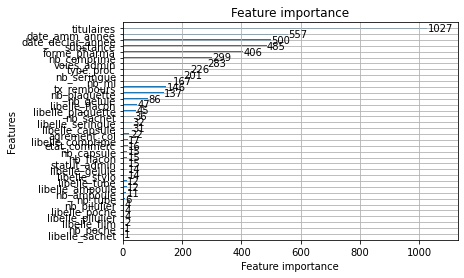

In [87]:
lgb.plot_importance(grid_pipeline.best_estimator_["lgbm"])

## Cross Val on pipeline

### Sklearn CV

Now that we have the best params lets apply CV to see what we get

In [33]:
# Cross-validation MSE
pipe.set_params(**grid_pipeline.best_params_, lgbm__early_stopping_rounds=100)

mse_scorer = sk.metrics.make_scorer(sk.metrics.mean_squared_error)
scores = sk.model_selection.cross_val_score(pipe, X_train_full, y_train_full,
                                            cv=4, scoring=mse_scorer)

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_

In [34]:
print('Cross-validated MSE: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

Cross-validated MSE: 3059.020 +/- 849.474


Results of some experiments :  
No scaler : Cross-validated MSE: 5191.406 +/- 382.631  
Scaler : Cross-validated MSE: 5156.074 +/- 400.101  
{'lgbm__learning_rate': 0.5,  
 'lgbm__max_depth': 2,  
 'lgbm__n_estimators': 10,  
 'lgbm__num_leaves': 20,  
 'verbose': 0}  
With best param : Cross-validated MSE: 4384.415 +/- 549.374  
All features no param opt : Cross-validated MSE: 3949.158 +/- 696.131  
No param tuning all merged : Cross-validated MSE: 3050.137 +/- 692.955  

That's for us to see if the model perform as well (in the range found previously) on a bigger data set (no CV)

In [82]:
# MSE on test data
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_valid)
test_mse = sk.metrics.mean_squared_error(y_valid, y_pred)
print('Validation MSE: %0.3f' % test_mse)

/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Validation MSE: 3427.790


### My CV

We realized that sklearn cross validation was not giving us the oportunity to perform validation at each fold so we could not monitor overfitting of the models  
Plus we had no access to the trained models to perform ensemble methods (bagging, stacking ...)

In [3]:
def cv(X_train, y_train):
    '''
    This is a fonction to perform crossvalidation
    '''

    # Choose the folding strategy :
    ## KFold is simple
    # RepeatedKFold allows to loop multiple time over the dataset providing more folds and therefore more models
    # Bagging through cross-validation
    # folds = sk.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    folds = sk.model_selection.RepeatedKFold(
        n_splits=5, n_repeats=5, random_state=42)

    mse_scorer = sk.metrics.make_scorer(sk.metrics.mean_squared_error)

    # This is to store the models and results for each fold
    results = {}
    models = {}

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
        print("fold n°{}".format(fold_))

        X_inner = X_train.iloc[trn_idx]
        X_outer = X_train.iloc[val_idx]
        y_inner = y_train.iloc[trn_idx]
        y_outer = y_train.iloc[val_idx]

        # Models
        preprocessing = Pipeline([
            #("label_encoding", ce.ordinal.OrdinalEncoder(cols=label_encoding_col)),
            ("tfidf", ce.count.CountEncoder(cols=tfidf_col,
                                            combine_min_nan_groups=True, min_group_size=0.01)),
            ("taget", ce.target_encoder.TargetEncoder(
                cols=target_col+label_encoding_col))
        ])

        # Preprocessing
        X_inner_proc = preprocessing.fit_transform(X_inner, y_inner)
        X_outer_proc = preprocessing.transform(X_outer)

        params = {
            "n_estimators": 500,
            "early_stopping_rounds": 30,
            "min_data_in_leaf": 150,
            "feature_fraction": 0.7,
            "bagging_fraction": 0.7,
            "bagging_freq": 10,
            "learning_rate": 0.03,
            "max_depth": 12,
            "num_leaves": 60
        }

        # There I set the random_State at a multiple of the fold_ so that each fold as a different seed but its still repeatable
        lgbm = lgb.LGBMRegressor(
            importance_type="gain", **params, random_state=42*fold_)

        lgbm.fit(
            X_inner_proc, y_inner,
            eval_set=[(X_inner_proc, y_inner), (X_outer_proc, y_outer)],
            eval_metric=["MSE"],
            verbose=250,
        )

        # Prediction
        pred = lgbm.predict(X_outer_proc)
        results[fold_] = sk.metrics.mean_squared_error(y_outer, pred)
        models[fold_] = (preprocessing, lgbm)
    return results, models

In [172]:
results, models = cv(X_train_full, y_train_full)

fold n°0


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[90]	training's l2: 3595.6	valid_1's l2: 5202.97
fold n°1


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3549.55	valid_1's l2: 3344.37
[500]	training's l2: 3160.72	valid_1's l2: 3150.24
Did not meet early stopping. Best iteration is:
[500]	training's l2: 3160.72	valid_1's l2: 3150.24
fold n°2


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3617.75	valid_1's l2: 3163.13
Early stopping, best iteration is:
[350]	training's l2: 3415.77	valid_1's l2: 3076.79
fold n°3


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3506.53	valid_1's l2: 3232.92
Early stopping, best iteration is:
[240]	training's l2: 3518.09	valid_1's l2: 3229.21
fold n°4


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3162.52	valid_1's l2: 4931.39
[500]	training's l2: 2861.02	valid_1's l2: 4603.54
Did not meet early stopping. Best iteration is:
[500]	training's l2: 2861.02	valid_1's l2: 4603.54
fold n°5


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3469.67	valid_1's l2: 3619.3
Early stopping, best iteration is:
[303]	training's l2: 3357.05	valid_1's l2: 3558.04
fold n°6


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3660.79	valid_1's l2: 2649.95
Early stopping, best iteration is:
[290]	training's l2: 3582.25	valid_1's l2: 2587.93
fold n°7


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3319.84	valid_1's l2: 4461.24
Early stopping, best iteration is:
[280]	training's l2: 3274.27	valid_1's l2: 4407.45
fold n°8


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3128.17	valid_1's l2: 5197.56
Early stopping, best iteration is:
[300]	training's l2: 3041.97	valid_1's l2: 5114.85
fold n°9


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	training's l2: 4025.59	valid_1's l2: 3524.15
fold n°10


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3400.76	valid_1's l2: 3829.45
Early stopping, best iteration is:
[339]	training's l2: 3218.29	valid_1's l2: 3794.49
fold n°11


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3493.38	valid_1's l2: 3114.87
[500]	training's l2: 3149.66	valid_1's l2: 2946.82
Did not meet early stopping. Best iteration is:
[500]	training's l2: 3149.66	valid_1's l2: 2946.82
fold n°12


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3251.1	valid_1's l2: 4637.85
[500]	training's l2: 2933.06	valid_1's l2: 4352.23
Did not meet early stopping. Best iteration is:
[500]	training's l2: 2933.06	valid_1's l2: 4352.23
fold n°13


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3301.01	valid_1's l2: 3845.22
[500]	training's l2: 2979.3	valid_1's l2: 3659.51
Did not meet early stopping. Best iteration is:
[500]	training's l2: 2979.3	valid_1's l2: 3659.51
fold n°14


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3390.27	valid_1's l2: 3589.79
Early stopping, best iteration is:
[347]	training's l2: 3266.64	valid_1's l2: 3505.61
fold n°15


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3300.86	valid_1's l2: 4155.24
[500]	training's l2: 2981.73	valid_1's l2: 3966.65
Did not meet early stopping. Best iteration is:
[500]	training's l2: 2981.73	valid_1's l2: 3966.65
fold n°16


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3110.91	valid_1's l2: 5201.85
Early stopping, best iteration is:
[301]	training's l2: 3031.59	valid_1's l2: 5125.91
fold n°17


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3513.51	valid_1's l2: 3392.29
[500]	training's l2: 3233.86	valid_1's l2: 3127
Did not meet early stopping. Best iteration is:
[500]	training's l2: 3233.86	valid_1's l2: 3127
fold n°18


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[79]	training's l2: 3966.25	valid_1's l2: 3614.4
fold n°19


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3521.75	valid_1's l2: 3373.39
Early stopping, best iteration is:
[325]	training's l2: 3388.17	valid_1's l2: 3288.07
fold n°20


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3511.61	valid_1's l2: 3380.88
[500]	training's l2: 3170.08	valid_1's l2: 3151.56
Did not meet early stopping. Best iteration is:
[500]	training's l2: 3170.08	valid_1's l2: 3151.56
fold n°21


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[149]	training's l2: 3822.91	valid_1's l2: 3015.94
fold n°22


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3160.31	valid_1's l2: 4913.69
[500]	training's l2: 2866.16	valid_1's l2: 4667.46
Did not meet early stopping. Best iteration is:
[500]	training's l2: 2866.16	valid_1's l2: 4667.46
fold n°23


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3292.47	valid_1's l2: 4585.55
[500]	training's l2: 2959.89	valid_1's l2: 4317.61
Did not meet early stopping. Best iteration is:
[500]	training's l2: 2959.89	valid_1's l2: 4317.61
fold n°24


/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/Caskroom/miniconda/base/envs/Kaggle/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
Training until validation scores don't improve for 30 rounds
[250]	training's l2: 3367.74	valid_1's l2: 3994.59
Early stopping, best iteration is:
[467]	training's l2: 3113.69	valid_1's l2: 3841.97


In [173]:
print(
    f"avg = {np.mean(list(results.values()))}, std = {np.std(list(results.values()))}")

avg = 3793.216384310136, std = 729.8598121692685


### Notes params

First trying to understand the impact of the chosen encoders

TargetEncoder : avg = 3278.134666266537, std = 845.3718815476491  
Catboost : avg = 3321.4409260150437, std = 702.9297278772179  
All catboost : avg = 3248.610689713285, std = 668.762145429176  
All cat boost (sgma = 1) : avg = 3422.9400344174874, std = 672.2864610282703 --> low overfitting  
all Target : avg = 3286.768693051416, std = 832.8772463195282 --> high Overfitting    
Un peu des deux  : avg = 3248.270578685235, std = 293.6312364649877  
with param for overfitting prevention : very low overfitting avg = 4036.7005089932995, std = 283.2577024517627  

Then trying to prevent overfitting by changing the parameters of the LGBM while not loosing on the total score  
Overfitting is the difference between the train and the validation score (I kept no trace of overfiting values 🤦‍♂️)

### Some kind of bagging

With access to the trained model We can do some bagging  
Each model is slightly different because it is trained on different folds  

In [174]:
pred = 0

# Get all the predictions
for idx, mods in models.items():
    exclude = []  # index of the model to exclude
    if(idx not in exclude):  # Not taking ito account the bad ones
        preprocessing, lgbm = mods
        pred += lgbm.predict(preprocessing.transform(X_valid)
                             )/(len(models)-len(exclude))

In [152]:
print(sk.metrics.mean_squared_error(y_valid, pred))

3902.5437642892384


I tried diffent bogging strategy but with no better results 
+ Weighting model prediction on there validation results
+ Removing the least performing model
+ For each data point : average on values except min and max prediction  
  
All models : 3376.3407917628315  
Worse removed : 3493.289789408218

In [ ]:
#inv_score = [1000/val for val in results.values()]
#sum_score = np.sum(inv_score)

# pred+=lgbm.predict(preprocessing.transform(X_valid))*inv_score[idx]/(sum_score)
# pred+=lgbm.predict(preprocessing.transform(X_submit))*inv_score[idx]/(sum_score)


#
# Bagging strategy
# def bag(preds):
#     preds = np.delete(preds, np.argmax(preds))
#     preds = np.delete(preds, np.argmin(preds))
#     return np.mean(preds)
# final = [bag(p) for p in pred.T[:,1]]
# print(len(final))
#print(sk.metrics.mean_squared_error(y_valid, pred))

### Stacking

I had a go at stacking, not enough time to make it better

In [134]:
params = {
    "n_estimators": 500,
    "min_data_in_leaf": 150,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "learning_rate": 0.04,
    "max_depth": 15,
    "num_leaves": 80
}

estimator = Pipeline([
    #("label_encoding", ce.ordinal.OrdinalEncoder(cols=label_encoding_col)),
    ("tfidf", ce.count.CountEncoder(cols=tfidf_col,
                                    combine_min_nan_groups=True, min_group_size=0.01)),
    ("taget", ce.target_encoder.TargetEncoder(cols=target_col+label_encoding_col)),
    ("lgbm", lgb.LGBMRegressor(importance_type="gain", **params))
])

estimators = [(f"estimator_{idx}", estimator) for idx in range(0, 5)]
final_estimator = lgb.LGBMRegressor(importance_type="gain")

stacker = sk.ensemble.StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5, passthrough=False, n_jobs=5, verbose=True)

In [135]:
stacker.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('estimator_0',
                               Pipeline(steps=[('tfidf',
                                                CountEncoder(cols=['voies '
                                                                   'admin',
                                                                   'forme '
                                                                   'pharma',
                                                                   'substance'],
                                                             combine_min_nan_groups=True,
                                                             min_group_size=0.01)),
                                               ('taget',
                                                TargetEncoder(cols=['titulaires',
                                                                    'statut',
                                                                    'agrement '
                

In [136]:
y_pred = stacker.predict(X_valid)
test_mse = sk.metrics.mean_squared_error(y_valid, y_pred)
print('Validation MSE: %0.3f' % test_mse)

Validation MSE: 3685.544


Passthrough False: Validation MSE: 2991.100

Stacking train multiple model and feeds their prediction into a final estimator.
I fall short of time on testing that fully, should have :
- tune final estimator
- tested more diverse models
- tested with passthrough

--> Might have also needed to be custom implemented (as CV) to be able to monitor overfitting

## Random forest test

Let's try random forest

In [83]:
pipe = Pipeline([
    ("label_encoding", MultiColumnLabelEncoder(to_target_encode)),
    #("scaler", sk.preprocessing.StandardScaler()),
    ("imputer", SimpleImputer(missing_values=np.nan, add_indicator=True,
                              strategy='mean')),
    ("rf", RandomForestRegressor())
])
mse_scorer = sk.metrics.make_scorer(sk.metrics.mean_squared_error)
scores = sk.model_selection.cross_val_score(pipe, X_train_full, y_train_full,
                                            cv=4, scoring=mse_scorer)

In [84]:
print('Cross-validated MSE: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

Cross-validated MSE: 4402.118 +/- 1045.570


Poor results as is ... Need tuning, let's return to Boosting Tree

## Submission

In [ ]:
y_sub = pipe.predict(X_submit)

In [175]:
idx = df_submission["id"]
sub = pd.DataFrame({"id": idx, "prix": pred})
sub.to_csv("13_12_sub_bagging_3793.csv", index=False)